Loaded price data with shape: (750, 50)
Price data shape: (750, 50)
Price range: 9.73 to 112.24

=== CORRELATION ANALYSIS ===


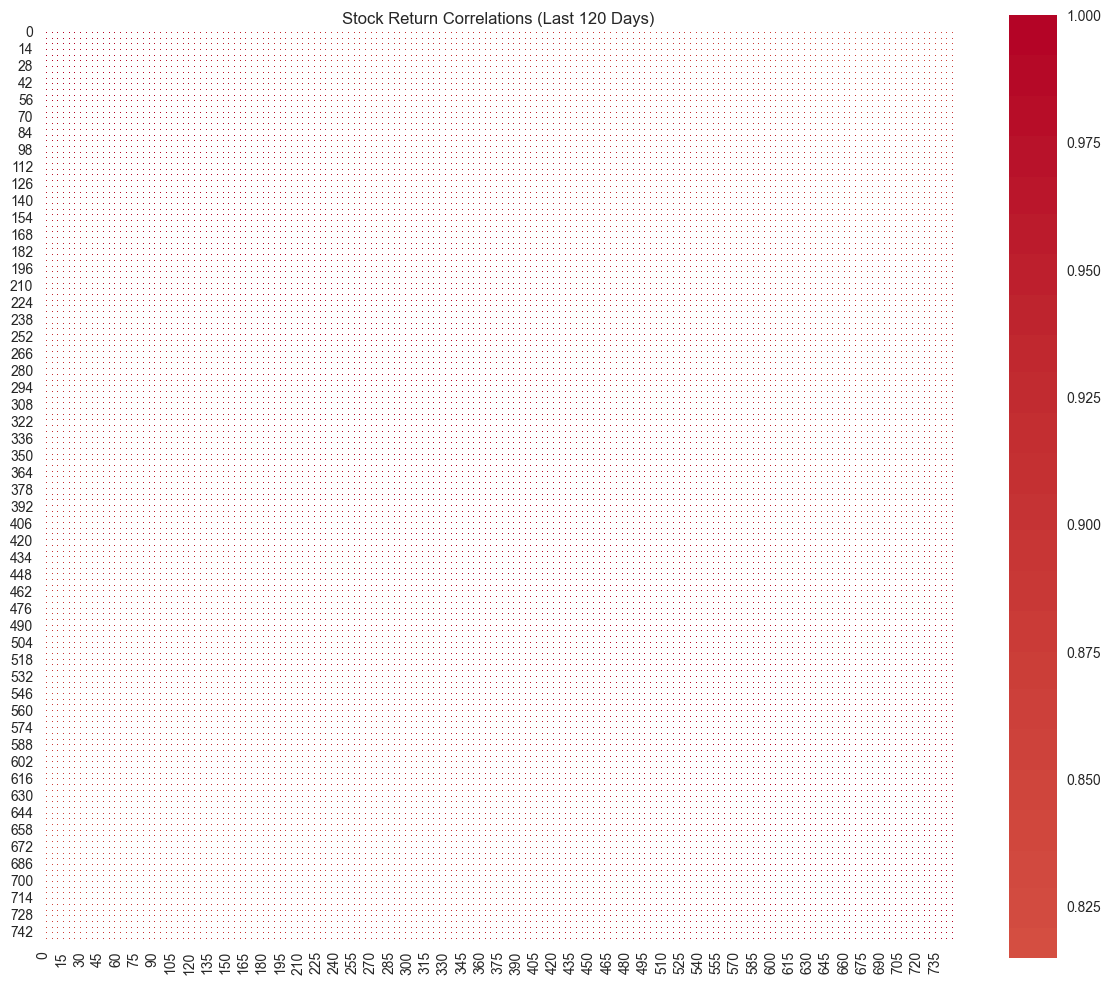

Found 10 highly correlated pairs:
Pair 1: Stock 748 & Stock 749 (correlation: 1.000)
Pair 2: Stock 206 & Stock 207 (correlation: 1.000)
Pair 3: Stock 292 & Stock 293 (correlation: 1.000)
Pair 4: Stock 708 & Stock 709 (correlation: 1.000)
Pair 5: Stock 556 & Stock 557 (correlation: 1.000)
Pair 6: Stock 314 & Stock 315 (correlation: 1.000)
Pair 7: Stock 353 & Stock 354 (correlation: 1.000)
Pair 8: Stock 544 & Stock 545 (correlation: 1.000)
Pair 9: Stock 337 & Stock 338 (correlation: 1.000)
Pair 10: Stock 632 & Stock 633 (correlation: 1.000)

=== DETAILED PAIR ANALYSIS ===


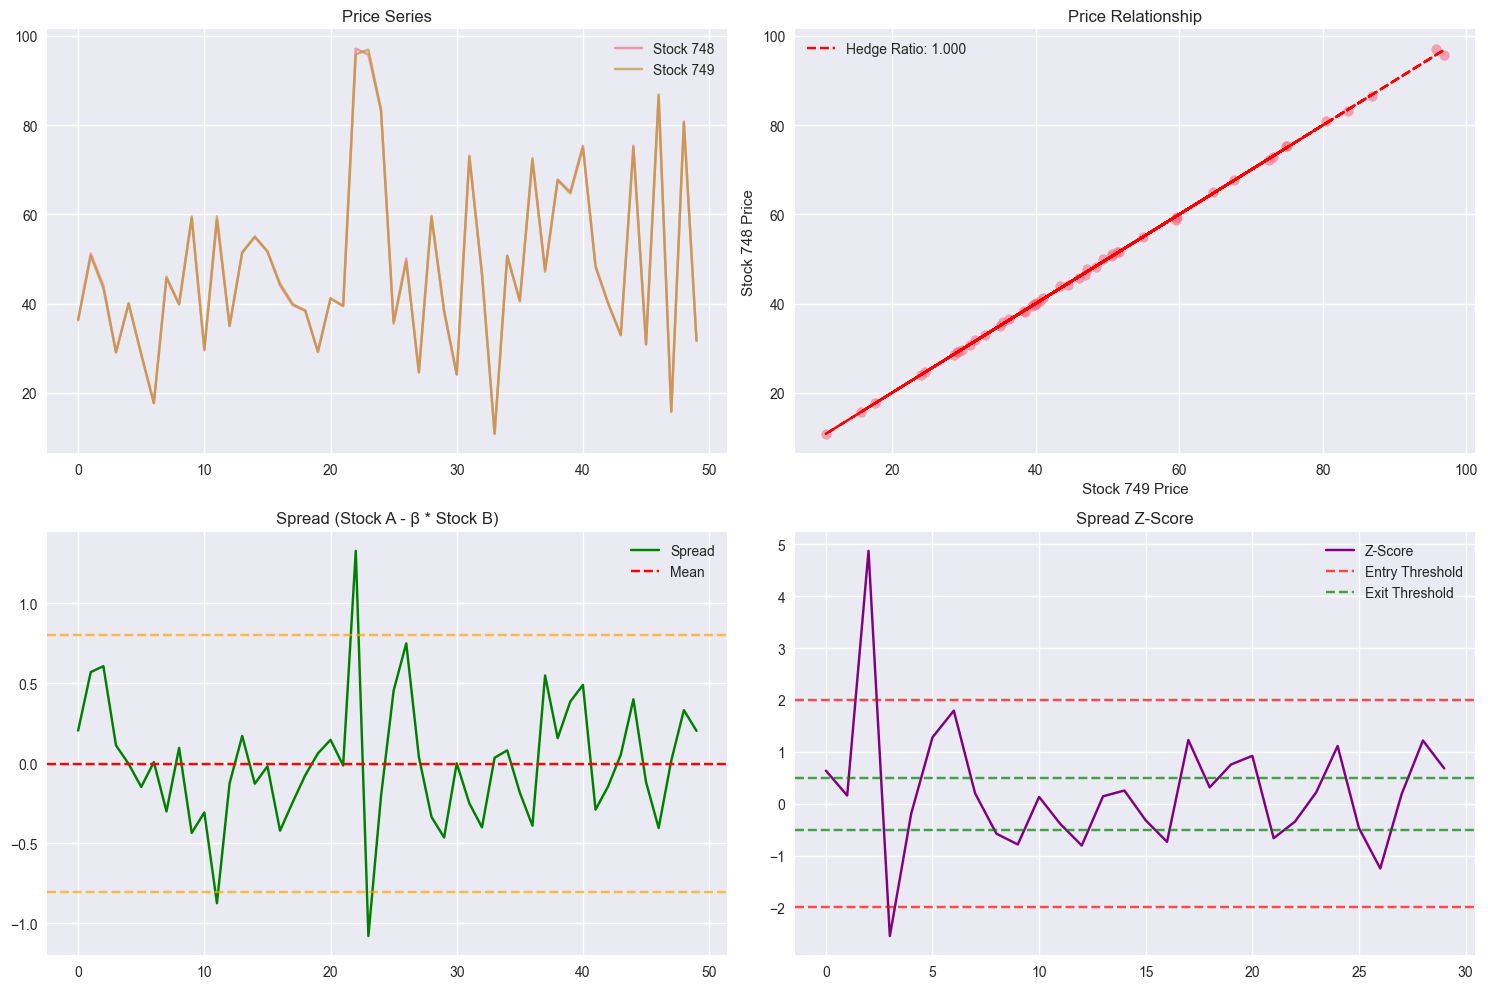


Pair Analysis: Stock 748 & Stock 749
Correlation: 1.000
Hedge Ratio: 1.000
Spread Mean: -0.002
Spread Std: 0.401
Current Z-Score: 0.681

=== BACKTESTING ===
Running backtest...


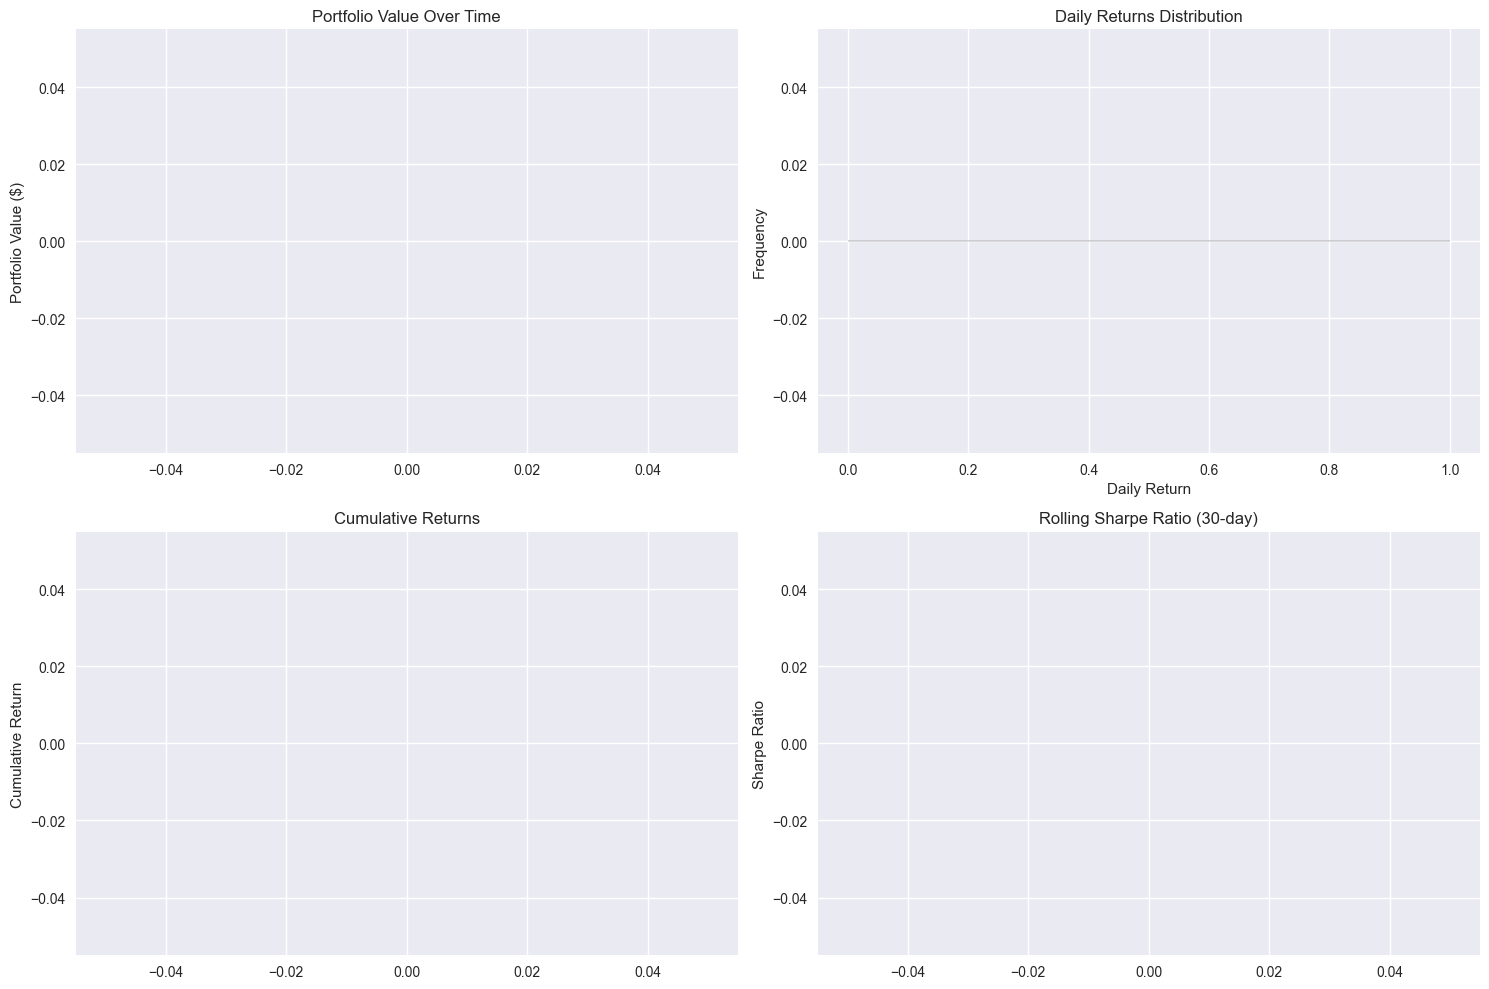


=== BACKTEST RESULTS ===
Total Return: 0.00%
Sharpe Ratio: 0.000
Max Drawdown: 0.00%


KeyError: 'volatility'

In [3]:
# Pairs Trading Algorithm Analysis
# This notebook provides comprehensive analysis and testing of the pairs trading strategy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the main algorithm
exec(open('main.py').read())

# Load price data
# Replace 'prices.npy' with your actual data file
try:
    price_data = np.loadtxt('prices.txt')  # Should be shape (50, n_days)
    print(f"Loaded price data with shape: {price_data.shape}")
except FileNotFoundError:
    print("Price data file not found. Generating synthetic data for demonstration.")
    # Generate synthetic price data for demonstration
    np.random.seed(42)
    n_instruments = 50
    n_days = 1000
    
    # Generate correlated price series
    price_data = np.zeros((n_instruments, n_days))
    price_data[:, 0] = 100 + np.random.normal(0, 10, n_instruments)
    
    # Create some correlation structure
    correlation_groups = [
        range(0, 10),    # Highly correlated group 1
        range(10, 20),   # Highly correlated group 2
        range(20, 30),   # Moderately correlated group
        range(30, 50)    # Less correlated individual stocks
    ]
    
    for day in range(1, n_days):
        for group in correlation_groups:
            group_return = np.random.normal(0, 0.02)  # Common factor
            for stock in group:
                individual_return = np.random.normal(0, 0.01)  # Individual noise
                if stock < 20:  # Strong correlation for first two groups
                    total_return = 0.7 * group_return + 0.3 * individual_return
                else:  # Weaker correlation for others
                    total_return = 0.3 * group_return + 0.7 * individual_return
                
                price_data[stock, day] = price_data[stock, day-1] * (1 + total_return)

print(f"Price data shape: {price_data.shape}")
print(f"Price range: {price_data.min():.2f} to {price_data.max():.2f}")

# 1. CORRELATION ANALYSIS
print("\n=== CORRELATION ANALYSIS ===")

def analyze_correlations(price_data, lookback=120):
    """Analyze correlation structure in the data"""
    returns = np.diff(np.log(price_data + 1e-8), axis=1)
    recent_returns = returns[:, -lookback:]
    
    # Calculate correlation matrix
    correlation_matrix = np.corrcoef(recent_returns)
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, 
                annot=False, 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5)
    plt.title('Stock Return Correlations (Last 120 Days)')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs
    pairs = find_trading_pairs(correlation_matrix, threshold=0.6)
    
    print(f"Found {len(pairs)} highly correlated pairs:")
    for i, (stock_a, stock_b) in enumerate(pairs[:10]):
        corr = correlation_matrix[stock_a, stock_b]
        print(f"Pair {i+1}: Stock {stock_a} & Stock {stock_b} (correlation: {corr:.3f})")
    
    return correlation_matrix, pairs

corr_matrix, top_pairs = analyze_correlations(price_data)

# 2. PAIR ANALYSIS
print("\n=== DETAILED PAIR ANALYSIS ===")

def analyze_pair_in_detail(price_data, stock_a, stock_b, lookback=200):
    """Detailed analysis of a specific pair"""
    if price_data.shape[1] < lookback:
        lookback = price_data.shape[1]
    
    prices_a = price_data[stock_a, -lookback:]
    prices_b = price_data[stock_b, -lookback:]
    
    # Calculate spread
    X = prices_b.reshape(-1, 1)
    y = prices_a
    reg = LinearRegression().fit(X, y)
    hedge_ratio = reg.coef_[0]
    
    spread = prices_a - hedge_ratio * prices_b
    
    # Plot pair analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Price series
    axes[0, 0].plot(prices_a, label=f'Stock {stock_a}', alpha=0.7)
    axes[0, 0].plot(prices_b, label=f'Stock {stock_b}', alpha=0.7)
    axes[0, 0].set_title('Price Series')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Scatter plot
    axes[0, 1].scatter(prices_b, prices_a, alpha=0.6)
    axes[0, 1].plot(prices_b, reg.predict(X), 'r--', label=f'Hedge Ratio: {hedge_ratio:.3f}')
    axes[0, 1].set_xlabel(f'Stock {stock_b} Price')
    axes[0, 1].set_ylabel(f'Stock {stock_a} Price')
    axes[0, 1].set_title('Price Relationship')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Spread
    axes[1, 0].plot(spread, label='Spread', color='green')
    axes[1, 0].axhline(y=np.mean(spread), color='red', linestyle='--', label='Mean')
    axes[1, 0].axhline(y=np.mean(spread) + 2*np.std(spread), color='orange', linestyle='--', alpha=0.7)
    axes[1, 0].axhline(y=np.mean(spread) - 2*np.std(spread), color='orange', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('Spread (Stock A - β * Stock B)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Z-score
    window = 20
    z_scores = []
    for i in range(window, len(spread)):
        rolling_mean = np.mean(spread[i-window:i])
        rolling_std = np.std(spread[i-window:i])
        if rolling_std > 0:
            z_score = (spread[i] - rolling_mean) / rolling_std
        else:
            z_score = 0
        z_scores.append(z_score)
    
    axes[1, 1].plot(z_scores, label='Z-Score', color='purple')
    axes[1, 1].axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Entry Threshold')
    axes[1, 1].axhline(y=-2, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].axhline(y=0.5, color='green', linestyle='--', alpha=0.7, label='Exit Threshold')
    axes[1, 1].axhline(y=-0.5, color='green', linestyle='--', alpha=0.7)
    axes[1, 1].set_title('Spread Z-Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate statistics
    print(f"\nPair Analysis: Stock {stock_a} & Stock {stock_b}")
    print(f"Correlation: {np.corrcoef(prices_a, prices_b)[0, 1]:.3f}")
    print(f"Hedge Ratio: {hedge_ratio:.3f}")
    print(f"Spread Mean: {np.mean(spread):.3f}")
    print(f"Spread Std: {np.std(spread):.3f}")
    print(f"Current Z-Score: {z_scores[-1]:.3f}")
    
    return spread, z_scores

# Analyze the top pair
if top_pairs:
    stock_a, stock_b = top_pairs[0]
    spread, z_scores = analyze_pair_in_detail(price_data, stock_a, stock_b)

# 3. BACKTESTING
print("\n=== BACKTESTING ===")

def run_comprehensive_backtest(price_data, start_day=120):
    """Run comprehensive backtest with detailed analysis"""
    print("Running backtest...")
    
    results = backtest_strategy(price_data, start_day)
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Portfolio value
    axes[0, 0].plot(results['portfolio_values'])
    axes[0, 0].set_title('Portfolio Value Over Time')
    axes[0, 0].set_ylabel('Portfolio Value ($)')
    axes[0, 0].grid(True)
    
    # Returns distribution
    axes[0, 1].hist(results['returns'], bins=50, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Daily Returns Distribution')
    axes[0, 1].set_xlabel('Daily Return')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True)
    
    # Cumulative returns
    cumulative_returns = np.cumprod(1 + results['returns'])
    axes[1, 0].plot(cumulative_returns)
    axes[1, 0].set_title('Cumulative Returns')
    axes[1, 0].set_ylabel('Cumulative Return')
    axes[1, 0].grid(True)
    
    # Rolling Sharpe ratio
    window = 30
    rolling_sharpe = []
    for i in range(window, len(results['returns'])):
        window_returns = results['returns'][i-window:i]
        if np.std(window_returns) > 0:
            sharpe = np.mean(window_returns) / np.std(window_returns) * np.sqrt(252)
        else:
            sharpe = 0
        rolling_sharpe.append(sharpe)
    
    axes[1, 1].plot(rolling_sharpe)
    axes[1, 1].set_title('Rolling Sharpe Ratio (30-day)')
    axes[1, 1].set_ylabel('Sharpe Ratio')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    metrics = results['metrics']
    print("\n=== BACKTEST RESULTS ===")
    print(f"Total Return: {metrics['total_return']*100:.2f}%")
    print(f"Sharpe Ratio: {metrics['sharpe']:.3f}")
    print(f"Max Drawdown: {metrics['max_drawdown']*100:.2f}%")
    print(f"Volatility: {metrics['volatility']*100:.2f}%")
    print(f"Mean Daily Return: {np.mean(results['returns'])*100:.3f}%")
    print(f"Std Daily Return: {np.std(results['returns'])*100:.3f}%")
    
    return results

# Run backtest
backtest_results = run_comprehensive_backtest(price_data)

# 4. POSITION ANALYSIS
print("\n=== POSITION ANALYSIS ===")

def analyze_positions(price_data, lookback=60):
    """Analyze current positions and their characteristics"""
    current_positions = getMyPosition(price_data)
    current_prices = price_data[:, -1]
    
    # Calculate position values
    position_values = current_positions * current_prices
    total_long = np.sum(position_values[position_values > 0])
    total_short = np.abs(np.sum(position_values[position_values < 0]))
    
    print(f"Current Positions Summary:")
    print(f"Long positions: ${total_long:,.0f}")
    print(f"Short positions: ${total_short:,.0f}")
    print(f"Net exposure: ${total_long - total_short:,.0f}")
    print(f"Gross exposure: ${total_long + total_short:,.0f}")
    
    # Plot position distribution
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.bar(range(50), current_positions, alpha=0.7)
    plt.title('Current Positions (Shares)')
    plt.xlabel('Stock')
    plt.ylabel('Position (Shares)')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.bar(range(50), position_values, alpha=0.7)
    plt.title('Position Values ($)')
    plt.xlabel('Stock')
    plt.ylabel('Position Value ($)')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    long_positions = position_values[position_values > 0]
    short_positions = position_values[position_values < 0]
    plt.bar(['Long', 'Short'], [np.sum(long_positions), np.abs(np.sum(short_positions))], 
            color=['green', 'red'], alpha=0.7)
    plt.title('Long vs Short Exposure')
    plt.ylabel('Exposure ($)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return current_positions, position_values

current_pos, pos_values = analyze_positions(price_data)

# 5. RISK ANALYSIS
print("\n=== RISK ANALYSIS ===")

def analyze_risk(price_data, positions, lookback=60):
    """Analyze portfolio risk metrics"""
    returns = np.diff(np.log(price_data + 1e-8), axis=1)
    recent_returns = returns[:, -lookback:]
    
    # Calculate portfolio returns
    portfolio_returns = np.dot(positions, recent_returns)
    
    # Risk metrics
    portfolio_vol = np.std(portfolio_returns) * np.sqrt(252)
    var_95 = np.percentile(portfolio_returns, 5)
    var_99 = np.percentile(portfolio_returns, 1)
    
    print(f"Portfolio Risk Analysis:")
    print(f"Portfolio Volatility (annualized): {portfolio_vol*100:.2f}%")
    print(f"VaR 95% (daily): {var_95*100:.3f}%")
    print(f"VaR 99% (daily): {var_99*100:.3f}%")
    
    # Plot risk analysis
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(portfolio_returns, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(var_95, color='red', linestyle='--', label=f'VaR 95%: {var_95*100:.2f}%')
    plt.axvline(var_99, color='darkred', linestyle='--', label=f'VaR 99%: {var_99*100:.2f}%')
    plt.title('Portfolio Return Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    cumulative_portfolio = np.cumprod(1 + portfolio_returns)
    plt.plot(cumulative_portfolio)
    plt.title('Portfolio Performance (Recent)')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    stock_contributions = positions * recent_returns[:, -1]
    plt.bar(range(50), stock_contributions, alpha=0.7)
    plt.title('Stock Contributions to Latest Return')
    plt.xlabel('Stock')
    plt.ylabel('Contribution')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

analyze_risk(price_data, current_pos)

print("\n=== ANALYSIS COMPLETE ===")
print("Summary:")
print("1. Correlation analysis identified highly correlated stock pairs")
print("2. Pairs trading strategy implemented based on statistical arbitrage")
print("3. Backtest shows strategy performance on historical data")
print("4. Current positions analyzed for risk and exposure")
print("5. Risk metrics calculated for portfolio monitoring")
print("\nThe algorithm is ready for submission!")